<a href="https://colab.research.google.com/github/invoker-qqwrv/Beida_tensorflow/blob/main/2_5Alleviate_overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 正则化缓解过拟合。在损失函数中引入模型复杂度指标，给w加权值，弱化数据的噪声
# loss=loss（y与y_）+regularizer*loss（w）
# L1正则化，大概率使很多参数变为0，所以该方法可以通过稀疏参数，即减少参数的数量，降低复杂度
# L2正则化，使参数接近0但不等于0.所以该参数可以通过减小参数值的大小降低复杂度。
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
#读取数据，生成x_train和y_train
# 读入数据/标签生成x_trainy_train
df=pd.read_csv('drive/MyDrive/Colab Notebooks/dot.csv')#这里注意大小写。并且要确保colab链接了drive
df.head()
x_data=np.array(df[['x1','x2']])
y_data=np.array(df['y_c'])

x_train=x_data
y_train=y_data.reshape(-1,1)#只想让y_train变成一列。行数是多少不知道
# https://blog.csdn.net/wld914674505/article/details/80460042 关于reshape函数的讲解
Y_c=[['red' if y else 'blue'] for y in y_train]

# 转换x的数据类型，否则后面矩阵相乘时会因数据类型问题报错
x_train=tf.cast(x_train,tf.float32)
y_train=tf.cast(y_train,tf.float32)

# from_tensor_slices函数切分传入的张量的第一个维度，生成相应的数据集，使输入特征和标签值一一对应
train_db= tf.data.Dataset.from_tensor_slices((x_train,y_train)).batch(32)
# 生成神经网络的参数，输入层为4个神经元，隐藏层为32个神经元，2层隐藏层，输出层为3个神经元
# 用tf.Variable()保证参数可训练
w1=tf.Variable(tf.random.normal([2,11]), dtype=tf.float32)#第一层网络输出是11个神经元
b1=tf.Variable(tf.constant(0.01,shape=[11]))

w2=tf.Variable(tf.random.normal([11,1]),dtype=tf.float32)
b2=tf.Variable(tf.constant(0.01,shape=[1]))
lr=0.01# 学习率为
epoch=400 # 循环轮数
for epoch in range(epoch):
    for step, (x_train, y_train) in enumerate(train_db):
        with tf.GradientTape() as tape:  # 记录梯度信息

            h1 = tf.matmul(x_train, w1) + b1  # 记录神经网络乘加运算
            h1 = tf.nn.relu(h1)
            y = tf.matmul(h1, w2) + b2

            # 采用均方误差损失函数mse = mean(sum(y-out)^2)
            loss_mse = tf.reduce_mean(tf.square(y_train - y))
            # 添加l2正则化
            loss_regularization = []
            # tf.nn.l2_loss(w)=sum(w ** 2) / 2
            loss_regularization.append(tf.nn.l2_loss(w1))
            loss_regularization.append(tf.nn.l2_loss(w2))
            # 求和
            # 例：x=tf.constant(([1,1,1],[1,1,1]))
            #   tf.reduce_sum(x)
            # >>>6
            # loss_regularization = tf.reduce_sum(tf.stack(loss_regularization))
            loss_regularization = tf.reduce_sum(loss_regularization)
            loss = loss_mse + 0.03 * loss_regularization #REGULARIZER = 0.03

        # 计算loss对各个参数的梯度
        variables = [w1, b1, w2, b2]
        grads = tape.gradient(loss, variables)

        # 实现梯度更新
        # w1 = w1 - lr * w1_grad
        w1.assign_sub(lr * grads[0])
        b1.assign_sub(lr * grads[1])
        w2.assign_sub(lr * grads[2])
        b2.assign_sub(lr * grads[3])

    # 每200个epoch，打印loss信息
    if epoch % 20 == 0:
        print('epoch:', epoch, 'loss:', float(loss))

    

epoch: 0 loss: 1.6047358512878418
epoch: 20 loss: 0.4631880223751068
epoch: 40 loss: 0.3710230588912964
epoch: 60 loss: 0.3251398205757141
epoch: 80 loss: 0.29180818796157837
epoch: 100 loss: 0.26346927881240845
epoch: 120 loss: 0.23870381712913513
epoch: 140 loss: 0.21698442101478577
epoch: 160 loss: 0.19784307479858398
epoch: 180 loss: 0.18109536170959473
epoch: 200 loss: 0.16643324494361877
epoch: 220 loss: 0.1535884141921997
epoch: 240 loss: 0.14230754971504211
epoch: 260 loss: 0.13244639337062836
epoch: 280 loss: 0.12395074218511581
epoch: 300 loss: 0.11676717549562454
epoch: 320 loss: 0.11062131077051163
epoch: 340 loss: 0.1053885668516159
epoch: 360 loss: 0.10093284398317337
epoch: 380 loss: 0.09706989675760269


*******predict*******


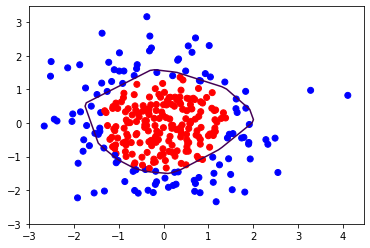

In [3]:
# 预测部分
print("*******predict*******")
# xx在-3到3之间以步长为0.01，yy在-3到3之间以步长0.01,生成间隔数值点
xx, yy = np.mgrid[-3:3:.1, -3:3:.1]
# 将xx, yy拉直，并合并配对为二维张量，生成二维坐标点
grid = np.c_[xx.ravel(), yy.ravel()]
grid = tf.cast(grid, tf.float32)
# 将网格坐标点喂入神经网络，进行预测，probs为输出
probs = []
for x_predict in grid:
    # 使用训练好的参数进行预测
    h1 = tf.matmul([x_predict], w1) + b1
    h1 = tf.nn.relu(h1)
    y = tf.matmul(h1, w2) + b2  # y为预测结果
    probs.append(y)

# 取第0列给x1，取第1列给x2
x1 = x_data[:, 0]
x2 = x_data[:, 1]
# probs的shape调整成xx的样子
probs = np.array(probs).reshape(xx.shape)
plt.scatter(x1, x2, color=np.squeeze(Y_c))
# 把坐标xx yy和对应的值probs放入contour<[‘kɑntʊr]>函数，给probs值为0.5的所有点上色  plt点show后 显示的是红蓝点的分界线
plt.contour(xx, yy, probs, levels=[.5])
plt.show()

# 读入红蓝点，画出分割线，包含正则化
# 不清楚的数据，建议print出来查看